In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Libraries

In [ ]:
 # !pip install pyspark

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, StringType
from pyspark.sql.functions import udf


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Reading Parquet File

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/BPI Internship/NBA/WIN_DATAPREP_FINAL_MOCK.parquet")
df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,CST_SINCE
0,157105.0,2023-09-28,SNACKS,Lay's,Monthly,2023-08-09
1,374554.0,2024-03-17,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious,2022-01-08
2,374554.0,2024-03-12,HEALTH & WELLNESS,Garden of Life,Cost-Conscious,2022-01-13
3,374554.0,2022-04-03,SNACKS,Lay's,Cost-Conscious,2022-01-09
4,374554.0,2022-02-26,SNACKS,Lay's,Cost-Conscious,2022-01-09


## Summary Statistics and Info

In [ ]:
df.describe(include='all')

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,CST_SINCE
count,161691.000000,161691,161691,161691,161691,161691
unique,NaN,NaN,6,128,4,NaN
top,NaN,NaN,SNACKS,Lay's,Cost-Conscious,NaN
freq,NaN,NaN,91823,52606,90588,NaN
mean,500337.239970,2020-10-13 12:21:41.950015744,NaN,NaN,NaN,2015-09-16 13:08:05.392508160
min,19.000000,1986-11-16 00:00:00,NaN,NaN,NaN,1993-01-16 00:00:00
25%,251882.000000,2019-09-12 00:00:00,NaN,NaN,NaN,2011-07-11 00:00:00
50%,498990.000000,2021-10-19 00:00:00,NaN,NaN,NaN,2018-04-29 00:00:00
75%,749533.000000,2023-02-24 00:00:00,NaN,NaN,NaN,2021-10-24 00:00:00
max,999991.000000,2024-04-24 00:00:00,NaN,NaN,NaN,2024-01-16 00:00:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161691 entries, 0 to 179636
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CST_ID         161691 non-null  float64       
 1   TRANS_DATE     161691 non-null  datetime64[ns]
 2   PRODUCT_TYPE   161691 non-null  object        
 3   PRODUCT_BRAND  161691 non-null  object        
 4   SHOPPER        161691 non-null  object        
 5   CST_SINCE      161691 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 8.6+ MB


#Data Cleaning

## Remove `CST_SINCE`

In [ ]:
df[df['CST_ID'] == 6009.0]

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,CST_SINCE
29835,6009.0,1999-09-02,HEALTH & WELLNESS,Nature's Bounty,Luxurious,2002-12-21


Since `CST_SINCE` is a problematic feature with varying dates for the same `CST_ID` and having dates greater than the `TRANS_DATE`, we remove this column.

In [ ]:
df.drop(columns=['CST_SINCE'], inplace=True)
df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER
0,157105.0,2023-09-28,SNACKS,Lay's,Monthly
1,374554.0,2024-03-17,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious
2,374554.0,2024-03-12,HEALTH & WELLNESS,Garden of Life,Cost-Conscious
3,374554.0,2022-04-03,SNACKS,Lay's,Cost-Conscious
4,374554.0,2022-02-26,SNACKS,Lay's,Cost-Conscious


## Convert TRANS_DATE to datetime

In [ ]:
# Convert TRANS_DATE to datetime
df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])

In [ ]:
df.dtypes

CST_ID                  float64
TRANS_DATE       datetime64[ns]
PRODUCT_TYPE             object
PRODUCT_BRAND            object
SHOPPER                  object
dtype: object

## Check for Null Values

In [ ]:
df.isnull().sum()

CST_ID           0
TRANS_DATE       0
PRODUCT_TYPE     0
PRODUCT_BRAND    0
SHOPPER          0
dtype: int64

## Sort by `TRANS_DATE`

In [ ]:
df = df.sort_values(by=['TRANS_DATE'])
df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER
33548,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious
15885,334094.0,1987-01-13,HEALTH & WELLNESS,Bulletproof,Cost-Conscious
116709,973756.0,1987-03-28,HEALTH & WELLNESS,Bulletproof,Luxurious
13369,803423.0,1987-04-16,HEALTH & WELLNESS,Bulletproof,Cost-Conscious
112280,728381.0,1987-06-15,HEALTH & WELLNESS,Bulletproof,Luxurious


## Check Unique Values

In [ ]:
dataset = df

for column in dataset.columns:
  unique_count = dataset[column].nunique()
  unique_values = dataset[column].unique()

  print(f'''
{column}
  {unique_values}
Length: {unique_count}
''')


CST_ID
  [517952. 334094. 973756. ... 925639. 454686.  44574.]
Length: 85164


TRANS_DATE
  <DatetimeArray>
['1986-11-16 00:00:00', '1987-01-13 00:00:00', '1987-03-28 00:00:00',
 '1987-04-16 00:00:00', '1987-06-15 00:00:00', '1987-07-22 00:00:00',
 '1987-10-10 00:00:00', '1988-08-09 00:00:00', '1988-12-07 00:00:00',
 '1988-12-25 00:00:00',
 ...
 '2024-04-15 00:00:00', '2024-04-16 00:00:00', '2024-04-17 00:00:00',
 '2024-04-18 00:00:00', '2024-04-19 00:00:00', '2024-04-20 00:00:00',
 '2024-04-21 00:00:00', '2024-04-22 00:00:00', '2024-04-23 00:00:00',
 '2024-04-24 00:00:00']
Length: 7532, dtype: datetime64[ns]
Length: 7532


PRODUCT_TYPE
  ['HEALTH & WELLNESS' 'MEAT & SEAFOOD' 'HOUSEHOLD & CLEANING SUPPLIES'
 'CONDIMENTS' 'BEVERAGES' 'SNACKS']
Length: 6


PRODUCT_BRAND
  ['Bulletproof' "Reno's" 'New Chapter' "Nature's Bounty" 'Mr. Clean'
 'Mr. Muscle' 'Domex' 'Surf' 'Clorox' 'Joy' 'Ariel' 'Zonrox' 'Lysol'
 'Blue Bay' 'Downy' "Aling Tonya's" 'Garden of Life' 'Tide'
 'Four Sigmatic' 'Gai

## Check all product brands each product type has

In [ ]:
# Group by PRODUCT_TYPE and aggregate the PRODUCT_BRAND values
grouped = df.groupby('PRODUCT_TYPE')['PRODUCT_BRAND'].unique()

# Print each PRODUCT_TYPE and its associated PRODUCT_BRAND values
for product_type, product_brands in grouped.items():
    print(f"PRODUCT_TYPE: {product_type}")
    print(f"PRODUCT_BRANDS: {', '.join(product_brands)}\n")

PRODUCT_TYPE: BEVERAGES
PRODUCT_BRANDS: Nestlé, Universal Robina, San Miguel, Coca-Cola

PRODUCT_TYPE: CONDIMENTS
PRODUCT_BRANDS: Del Monte, Silver Swan, Datu Puti, UFC, Ajinomoto

PRODUCT_TYPE: HEALTH & WELLNESS
PRODUCT_BRANDS: Bulletproof, New Chapter, Nature's Bounty, Garden of Life, Four Sigmatic, Gaia Herbs, Vital Proteins, MegaFood, SmartyPants Vitamins, Nordic Naturals, Vega, Thorne Research, Amazing Grass, NOW Foods

PRODUCT_TYPE: HOUSEHOLD & CLEANING SUPPLIES
PRODUCT_BRANDS: Mr. Clean, Mr. Muscle, Domex, Surf, Clorox, Joy, Ariel, Zonrox, Lysol, Downy, Tide, Pride, Palmolive, Cif, Safeguard

PRODUCT_TYPE: MEAT & SEAFOOD
PRODUCT_BRANDS: Reno's, Blue Bay, Aling Tonya's, Fresh Options, Magnolia Chicken, Mekeni, Fisher Farms, SeaKing, Monterey, Robina Farms, Pacific Bay

PRODUCT_TYPE: SNACKS
PRODUCT_BRANDS: Lay's, Wheat Thins, Ruffles, Triscuit, Chips Ahoy!, Pringles, Fritos, Fig Newtons, Goldfish, Clif Bar, Snyder's of Hanover, Teddy Grahams, Nature Valley, Larabar, Takis, Popcorn

## Add day of the week column

In [ ]:
# Add day of the week column
df['DAY_OF_WEEK'] = df['TRANS_DATE'].dt.day_name()

df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK
33548,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday
15885,334094.0,1987-01-13,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Tuesday
116709,973756.0,1987-03-28,HEALTH & WELLNESS,Bulletproof,Luxurious,Saturday
13369,803423.0,1987-04-16,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Thursday
112280,728381.0,1987-06-15,HEALTH & WELLNESS,Bulletproof,Luxurious,Monday


#`df` EDA

##Transactions Count each Day

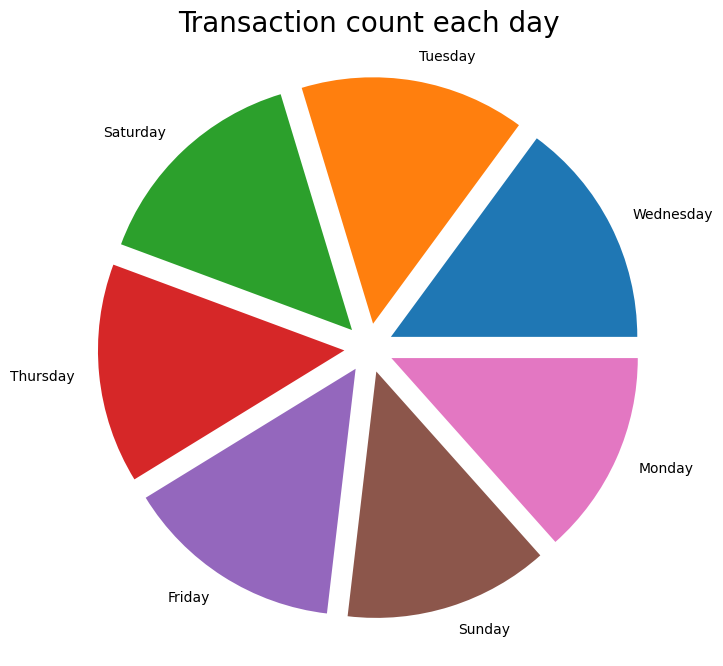

In [ ]:
df['DAY_OF_WEEK'].value_counts().plot.pie(figsize = (15, 8), explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))

plt.title('Transaction count each day',fontsize = 20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 90)
plt.show()

## `df` Countplots

Text(0.5, 1.0, 'Shopper Countplot')

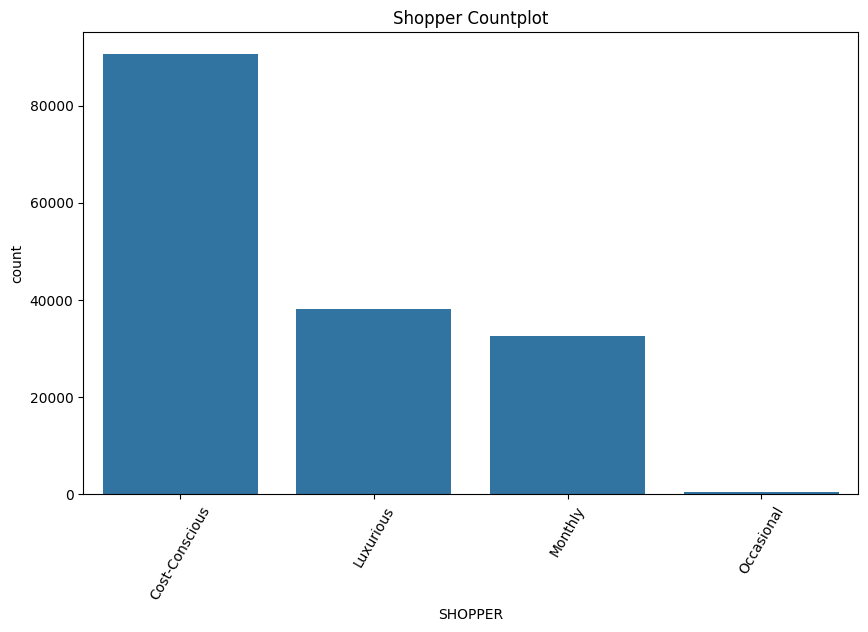

In [ ]:
# Compute the counts for each category
shopper_counts = df['SHOPPER'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = shopper_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='SHOPPER', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Shopper Countplot")

This is includes duplicates.

Text(0.5, 1.0, 'Product Type Countplot')

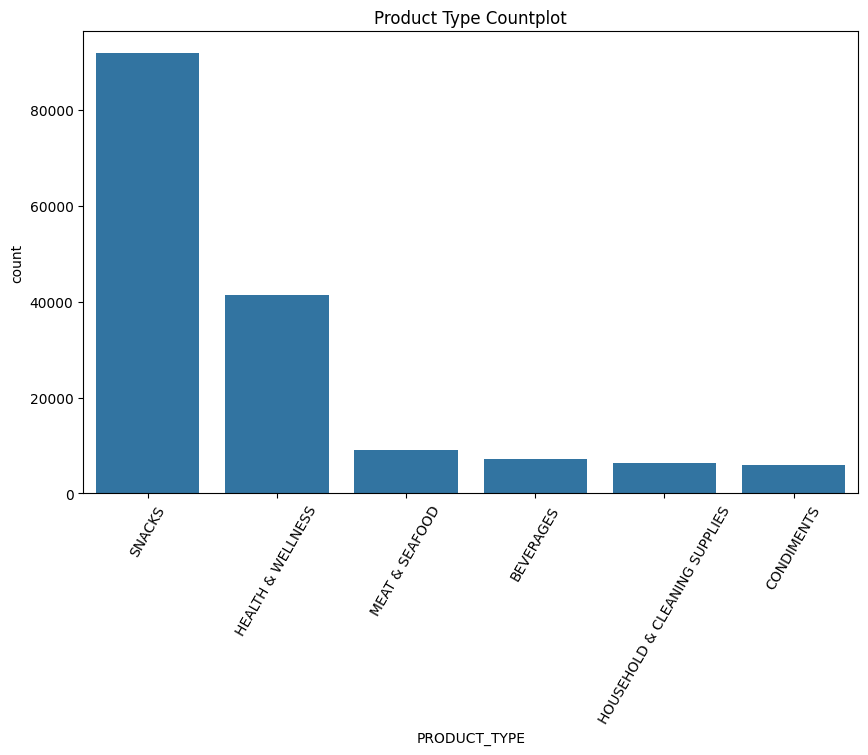

In [ ]:
# Compute the counts for each category
product_type_counts = df['PRODUCT_TYPE'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = product_type_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='PRODUCT_TYPE', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Product Type Countplot")

Text(0.5, 1.0, 'Product Brand Top 20 Countplot')

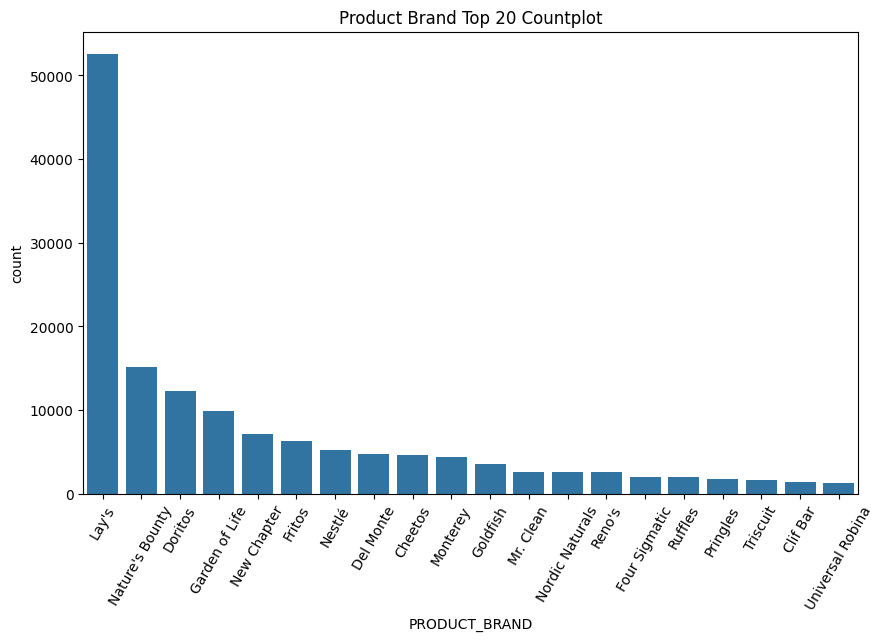

In [ ]:
# Compute the counts for each category
product_brand_counts = df['PRODUCT_BRAND'].value_counts()

# Select the top 20 product brands
top_20_brands = product_brand_counts.nlargest(20).index

# Filter the DataFrame to include only the top 20 product brands
df_top_20 = df[df['PRODUCT_BRAND'].isin(top_20_brands)]

# Create a countplot with the filtered data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_20, x='PRODUCT_BRAND', order=top_20_brands)
plt.xticks(rotation = 60)
plt.title("Product Brand Top 20 Countplot")

## Cost-Conscious Countplots

In [ ]:
cost_con = df[df['SHOPPER'] == 'Cost-Conscious']
cost_con.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK
15885,334094.0,1987-01-13,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Tuesday
13369,803423.0,1987-04-16,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Thursday
32890,471128.0,1988-12-07,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Wednesday
141194,208367.0,1989-01-05,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Thursday
176046,538152.0,1989-06-02,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Friday


Text(0.5, 1.0, 'Product Type Countplot')

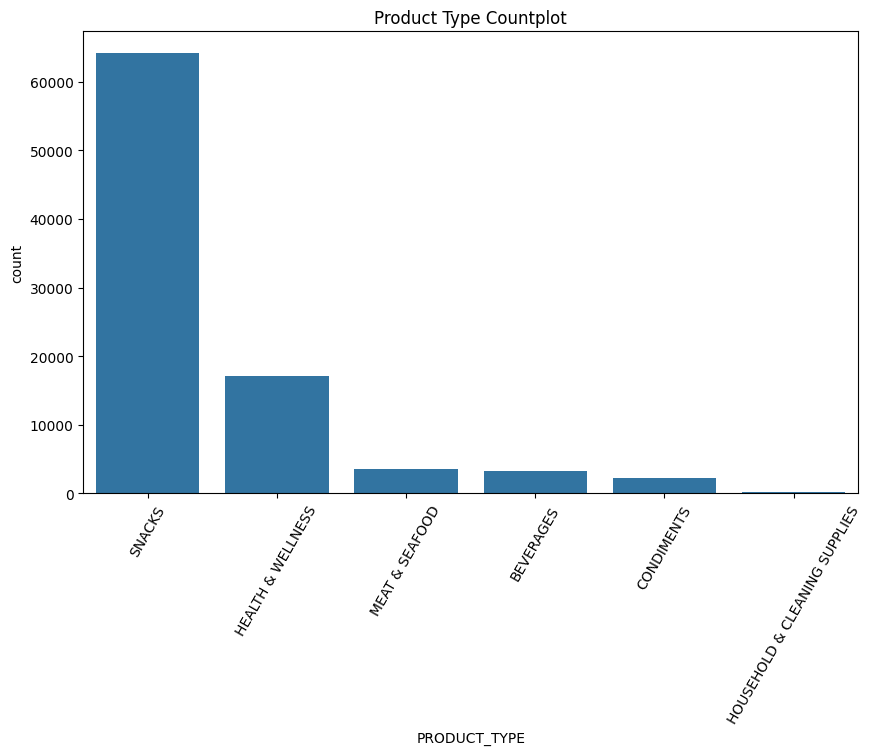

In [ ]:
# Compute the counts for each category
product_type_counts = cost_con['PRODUCT_TYPE'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = product_type_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=cost_con, x='PRODUCT_TYPE', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Product Type Countplot")

Text(0.5, 1.0, 'Product Brand Top 20 Countplot')

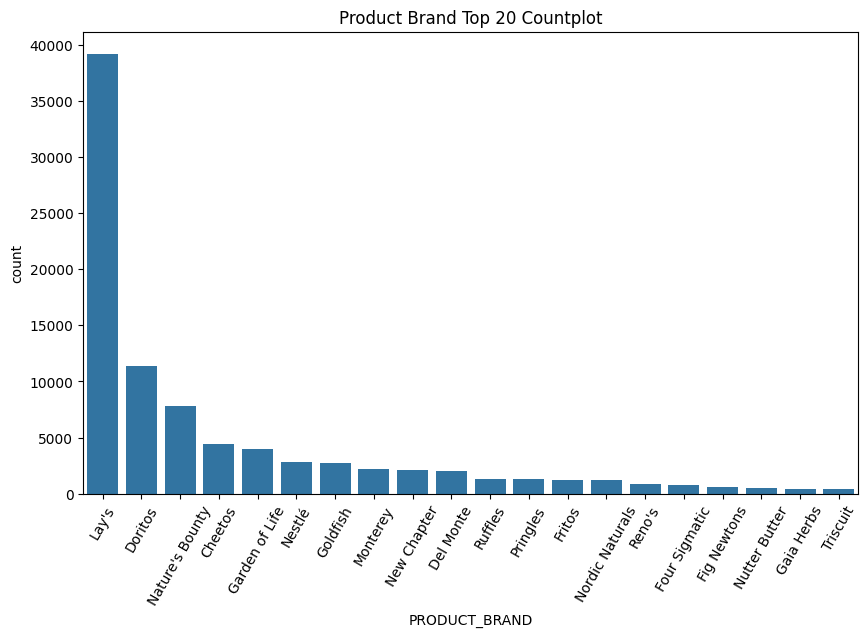

In [ ]:
# Compute the counts for each category
product_brand_counts = cost_con['PRODUCT_BRAND'].value_counts()

# Select the top 20 product brands
top_20_brands = product_brand_counts.nlargest(20).index

# Filter the DataFrame to include only the top 20 product brands
df_top_20 = cost_con[cost_con['PRODUCT_BRAND'].isin(top_20_brands)]

# Create a countplot with the filtered data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_20, x='PRODUCT_BRAND', order=top_20_brands)
plt.xticks(rotation = 60)
plt.title("Product Brand Top 20 Countplot")

## Luxurious Countplots

In [ ]:
lux = df[df['SHOPPER'] == 'Luxurious']
lux.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK
33548,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday
116709,973756.0,1987-03-28,HEALTH & WELLNESS,Bulletproof,Luxurious,Saturday
112280,728381.0,1987-06-15,HEALTH & WELLNESS,Bulletproof,Luxurious,Monday
127069,488420.0,1987-10-10,HEALTH & WELLNESS,Bulletproof,Luxurious,Saturday
86901,842514.0,1988-08-09,HEALTH & WELLNESS,Bulletproof,Luxurious,Tuesday


Text(0.5, 1.0, 'Product Type Countplot')

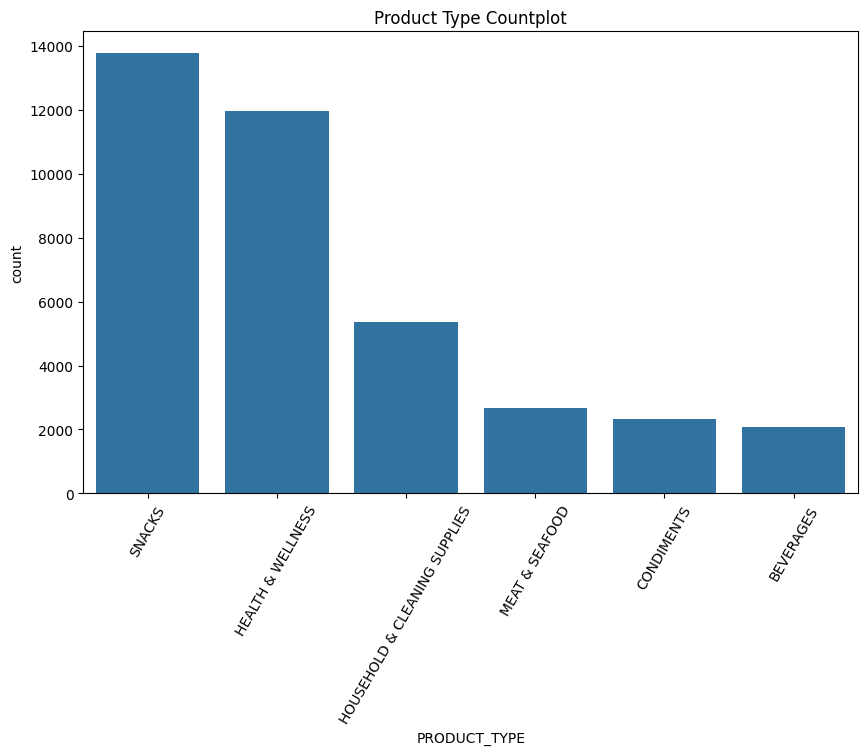

In [ ]:
# Compute the counts for each category
product_type_counts = lux['PRODUCT_TYPE'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = product_type_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=lux, x='PRODUCT_TYPE', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Product Type Countplot")

Text(0.5, 1.0, 'Product Brand Top 20 Countplot')

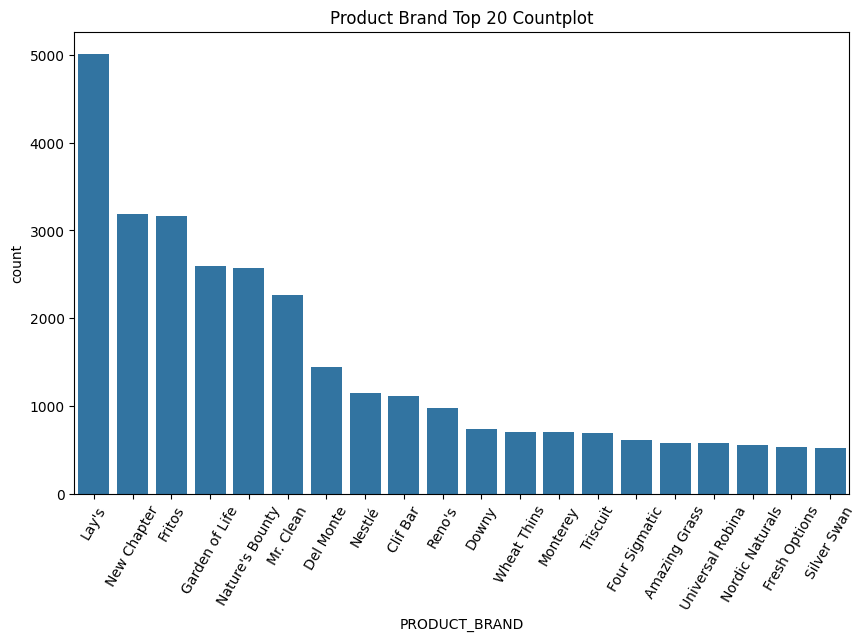

In [ ]:
# Compute the counts for each category
product_brand_counts = lux['PRODUCT_BRAND'].value_counts()

# Select the top 20 product brands
top_20_brands = product_brand_counts.nlargest(20).index

# Filter the DataFrame to include only the top 20 product brands
df_top_20 = lux[lux['PRODUCT_BRAND'].isin(top_20_brands)]

# Create a countplot with the filtered data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_20, x='PRODUCT_BRAND', order=top_20_brands)
plt.xticks(rotation = 60)
plt.title("Product Brand Top 20 Countplot")

## Monthly Countplots

In [ ]:
mon = df[df['SHOPPER'] == 'Monthly']
mon.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK
64526,926066.0,1987-07-22,HEALTH & WELLNESS,Bulletproof,Monthly,Wednesday
95542,760096.0,1990-05-26,HEALTH & WELLNESS,Bulletproof,Monthly,Saturday
145339,975853.0,1990-08-18,HEALTH & WELLNESS,Bulletproof,Monthly,Saturday
44162,158803.0,1991-05-14,HEALTH & WELLNESS,Bulletproof,Monthly,Tuesday
149029,802361.0,1992-02-07,HEALTH & WELLNESS,Bulletproof,Monthly,Friday


In [ ]:
mon.shape[0]

32526

Text(0.5, 1.0, 'Product Type Countplot')

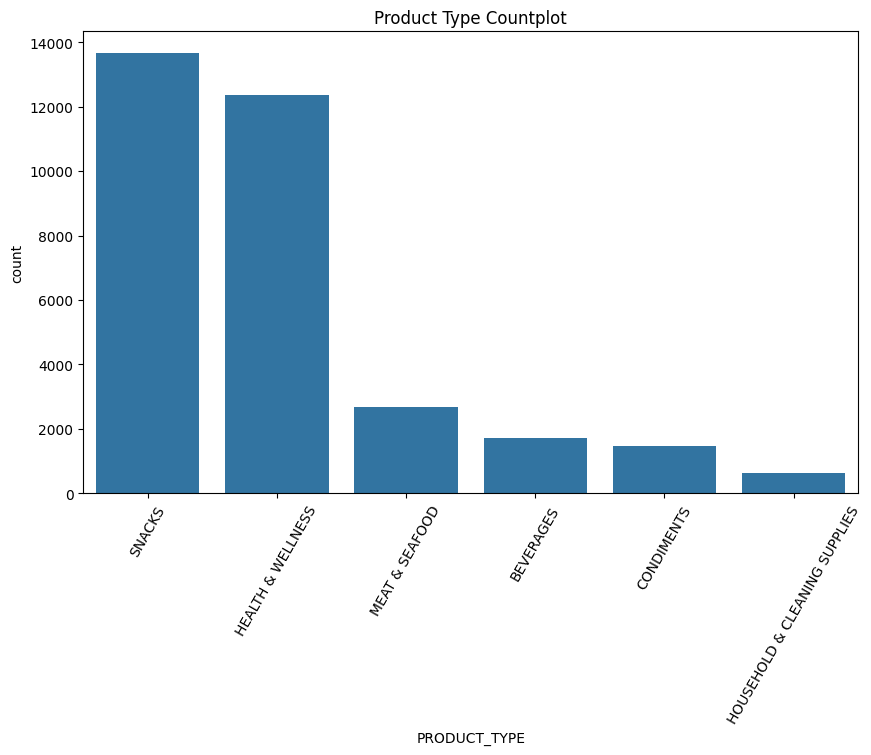

In [ ]:
# Compute the counts for each category
product_type_counts = mon['PRODUCT_TYPE'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = product_type_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=mon, x='PRODUCT_TYPE', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Product Type Countplot")

Text(0.5, 1.0, 'Product Brand Top 20 Countplot')

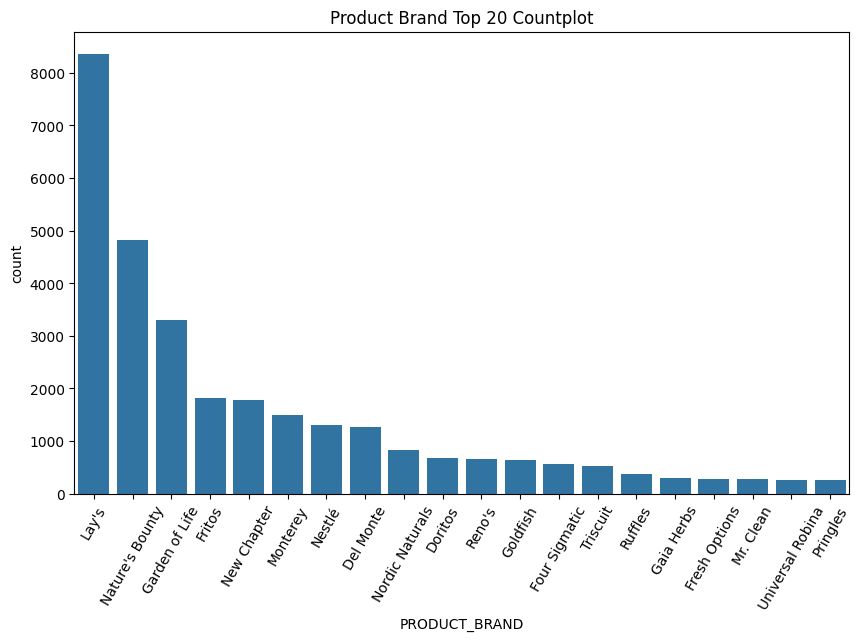

In [ ]:
# Compute the counts for each category
product_brand_counts = mon['PRODUCT_BRAND'].value_counts()

# Select the top 20 product brands
top_20_brands = product_brand_counts.nlargest(20).index

# Filter the DataFrame to include only the top 20 product brands
df_top_20 = mon[mon['PRODUCT_BRAND'].isin(top_20_brands)]

# Create a countplot with the filtered data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_20, x='PRODUCT_BRAND', order=top_20_brands)
plt.xticks(rotation = 60)
plt.title("Product Brand Top 20 Countplot")

## Occasional Countplots

In [ ]:
occ = df[df['SHOPPER'] == 'Occasional']
occ.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK
30426,941521.0,1996-10-25,HEALTH & WELLNESS,New Chapter,Occasional,Friday
131280,324028.0,2001-01-15,HEALTH & WELLNESS,New Chapter,Occasional,Monday
40218,439938.0,2002-08-20,HEALTH & WELLNESS,New Chapter,Occasional,Tuesday
115627,639607.0,2005-10-01,HOUSEHOLD & CLEANING SUPPLIES,Mr. Clean,Occasional,Saturday
115628,639607.0,2005-10-08,HOUSEHOLD & CLEANING SUPPLIES,Ariel,Occasional,Saturday


In [ ]:
occ.shape[0]

409

Text(0.5, 1.0, 'Product Type Countplot')

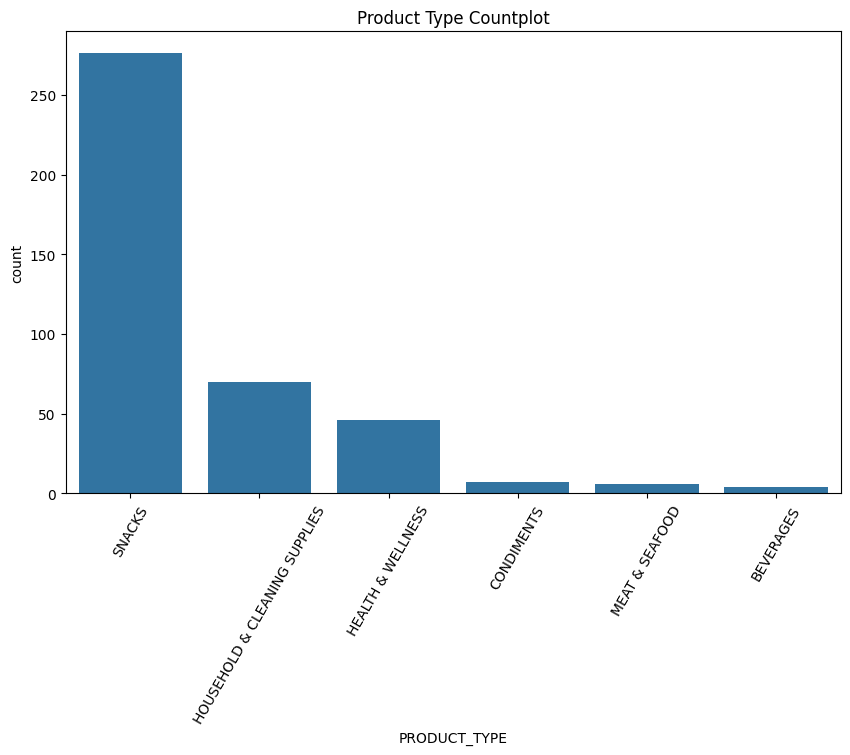

In [ ]:
# Compute the counts for each category
product_type_counts = occ['PRODUCT_TYPE'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = product_type_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=occ, x='PRODUCT_TYPE', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Product Type Countplot")

Text(0.5, 1.0, 'Product Brand Top 20 Countplot')

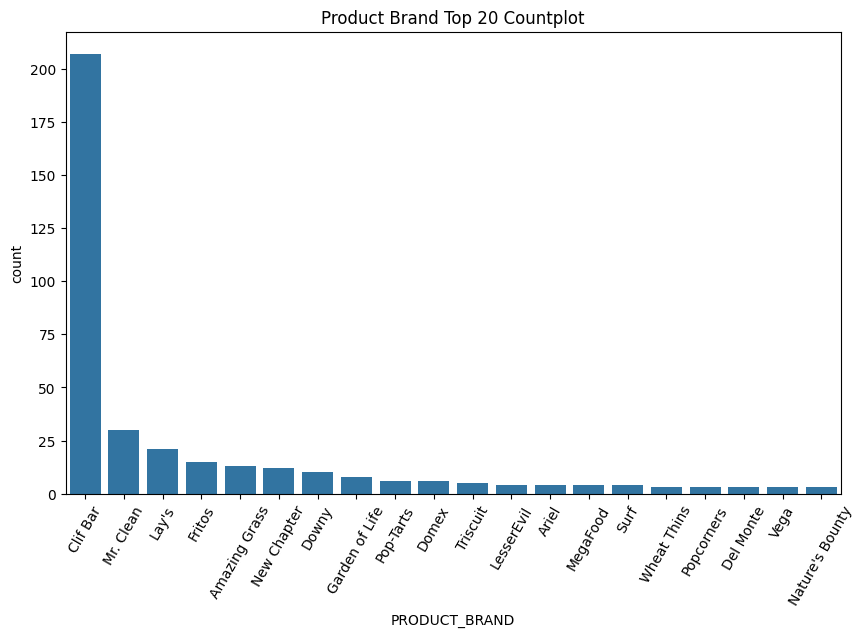

In [ ]:
# Compute the counts for each category
product_brand_counts = occ['PRODUCT_BRAND'].value_counts()

# Select the top 20 product brands
top_20_brands = product_brand_counts.nlargest(20).index

# Filter the DataFrame to include only the top 20 product brands
df_top_20 = occ[occ['PRODUCT_BRAND'].isin(top_20_brands)]

# Create a countplot with the filtered data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_20, x='PRODUCT_BRAND', order=top_20_brands)
plt.xticks(rotation = 60)
plt.title("Product Brand Top 20 Countplot")

Clif Bar is more popular among occasional shoppers compared to Lay's.

## Number of Transactions per Day

In [ ]:
# Group by TRANS_DATE and CST_ID, then count the number of transactions
df['TRANSACTION_COUNT_DAY'] = df.groupby(['TRANS_DATE', 'CST_ID'])['CST_ID'].transform('count')

In [ ]:
df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TRANSACTION_COUNT_DAY
33548,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday,1
15885,334094.0,1987-01-13,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Tuesday,1
116709,973756.0,1987-03-28,HEALTH & WELLNESS,Bulletproof,Luxurious,Saturday,1
13369,803423.0,1987-04-16,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Thursday,1
112280,728381.0,1987-06-15,HEALTH & WELLNESS,Bulletproof,Luxurious,Monday,1


Text(0.5, 1.0, 'Number of Transactions per Customer in 1 Day Countplot')

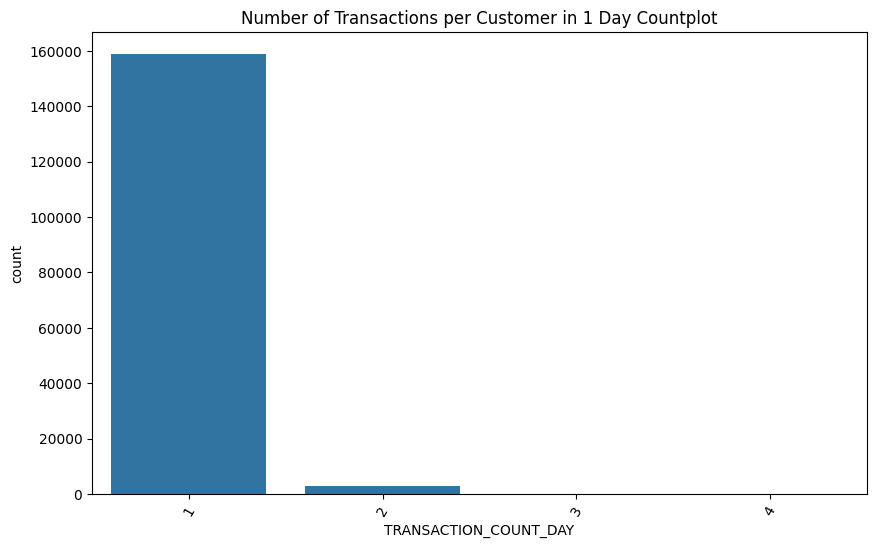

In [ ]:
# Compute the counts for each category
trans_counts = df['TRANSACTION_COUNT_DAY'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = trans_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='TRANSACTION_COUNT_DAY', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Number of Transactions per Customer in 1 Day Countplot")

In [ ]:
df['TRANSACTION_COUNT_DAY'].value_counts()

TRANSACTION_COUNT_DAY
1    158808
2      2810
3        69
4         4
Name: count, dtype: int64

In [ ]:
df[df['TRANS_DATE'] == '2024-04-24']

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TRANSACTION_COUNT_DAY
102644,372782.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Cost-Conscious,Wednesday,2
76619,124689.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Cost-Conscious,Wednesday,1
42154,70950.0,2024-04-24,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious,Wednesday,1
145854,609202.0,2024-04-24,SNACKS,Clif Bar,Luxurious,Wednesday,1
28849,44574.0,2024-04-24,SNACKS,Lay's,Luxurious,Wednesday,1
67529,743227.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Monthly,Wednesday,1
102646,372782.0,2024-04-24,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious,Wednesday,2
69272,230308.0,2024-04-24,SNACKS,Lay's,Cost-Conscious,Wednesday,1
170144,372071.0,2024-04-24,HEALTH & WELLNESS,Nordic Naturals,Cost-Conscious,Wednesday,1


Thus, the `TRANSACTION_COUNT_DAY` counts the number of transactions made by a customer in one day

In [ ]:
df[df['CST_ID'] == 	372782.0]

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TRANSACTION_COUNT_DAY
102648,372782.0,2023-08-17,SNACKS,Lay's,Cost-Conscious,Thursday,1
102647,372782.0,2023-08-29,SNACKS,Larabar,Cost-Conscious,Tuesday,1
102645,372782.0,2024-04-13,HEALTH & WELLNESS,Four Sigmatic,Cost-Conscious,Saturday,1
102644,372782.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Cost-Conscious,Wednesday,2
102646,372782.0,2024-04-24,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious,Wednesday,2


Customer that made transactions on different days.

# Feature Engineering

Added Features

* Number of Transactions per `CUST_ID`
* Difference between earliest and latest transaction

In [ ]:
agg_df = df.groupby('CST_ID').agg(
    COUNT=('CST_ID', 'size'),
    SHOPPER=('SHOPPER', 'first'),
    LAST_TRANS_DATE=('TRANS_DATE', 'max'),
    FIRST_TRANS_DATE=('TRANS_DATE', 'min'),
).reset_index()

agg_df['DIFF_DAYS'] = (agg_df['LAST_TRANS_DATE'] - agg_df['FIRST_TRANS_DATE']).dt.days

agg_df.head()

,CST_ID,COUNT,SHOPPER,LAST_TRANS_DATE,FIRST_TRANS_DATE,DIFF_DAYS
0,19.0,2,Luxurious,2023-12-21,2023-12-17,4
1,31.0,3,Luxurious,2019-02-21,2010-03-17,3263
2,36.0,1,Cost-Conscious,2023-08-09,2023-08-09,0
3,47.0,2,Cost-Conscious,2022-10-30,2014-05-17,3088
4,56.0,1,Cost-Conscious,2023-11-03,2023-11-03,0


# `agg_df` EDA

## Summary Statistics and Information

In [ ]:
agg_df.describe(include='all')

,CST_ID,COUNT,SHOPPER,LAST_TRANS_DATE,FIRST_TRANS_DATE,DIFF_DAYS
count,85164.000000,85164.000000,85164,85164,85164,85164.000000
unique,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,Cost-Conscious,NaN,NaN,NaN
freq,NaN,NaN,60545,NaN,NaN,NaN
mean,500972.692029,1.898584,NaN,2021-11-27 19:10:06.171621632,2020-08-22 19:18:27.341129728,461.994199
min,19.000000,1.000000,NaN,1992-10-06 00:00:00,1986-11-16 00:00:00,0.000000
25%,251864.250000,1.000000,NaN,2020-11-28 00:00:00,2019-08-02 00:00:00,0.000000
50%,500922.500000,1.000000,NaN,2022-08-23 00:00:00,2021-09-15 00:00:00,0.000000
75%,750092.000000,2.000000,NaN,2023-07-01 00:00:00,2023-02-04 00:00:00,363.000000
max,999991.000000,142.000000,NaN,2024-04-24 00:00:00,2024-04-24 00:00:00,13632.000000


In [ ]:
agg_df['CST_ID'].nunique()

85164

In [ ]:
agg_df.shape[0]

85164

## Shopper Countplot

Text(0.5, 1.0, 'Shopper Countplot')

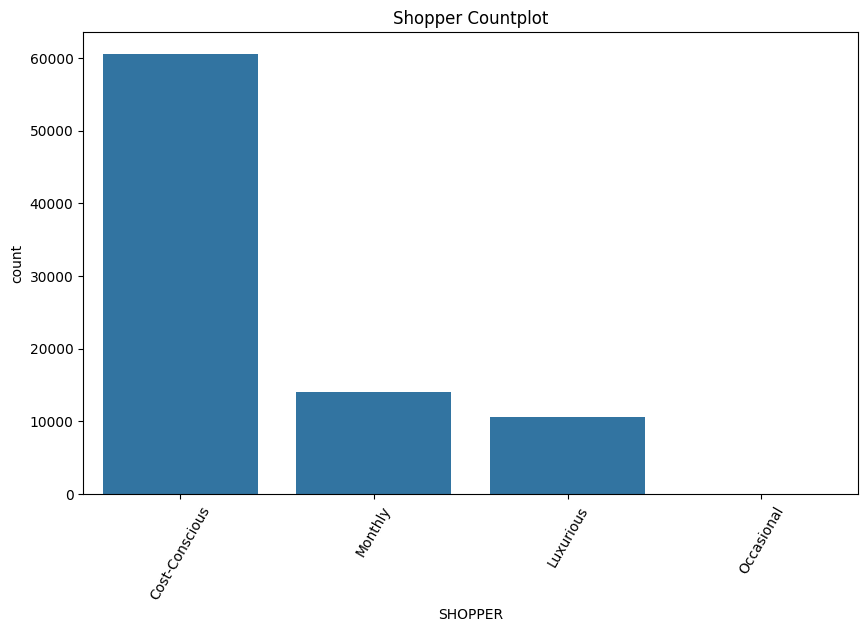

In [ ]:
# Compute the counts for each category
shopper_counts = agg_df['SHOPPER'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = shopper_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=agg_df, x='SHOPPER', order=sorted_categories)
plt.xticks(rotation = 60)
plt.title("Shopper Countplot")

This does not include duplicates.

In [ ]:
agg_df[agg_df["SHOPPER"] == 'Occasional'].shape[0]

32

There are only 32 occasional customers.

## Number of Transactions Countplot

Text(0.5, 1.0, 'COUNT Countplot')

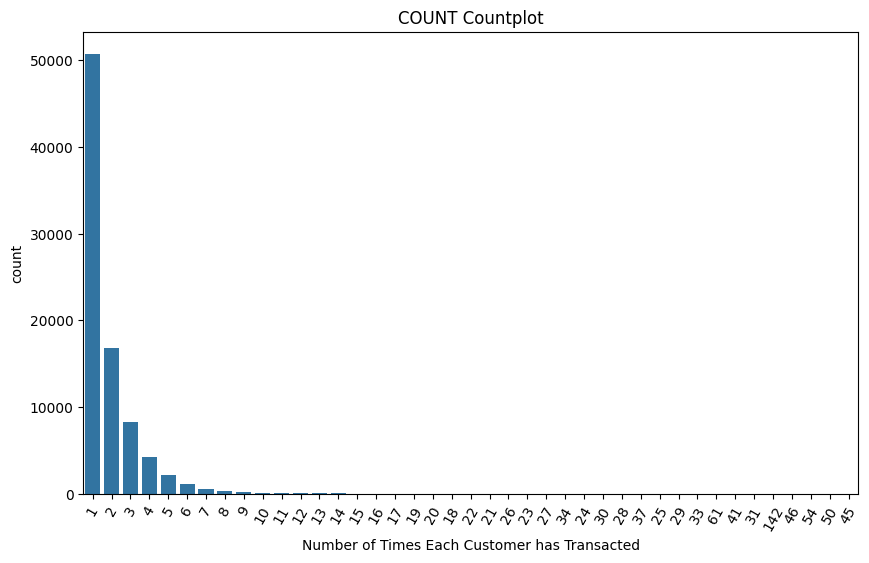

In [ ]:
# Compute the counts for each category
COUNT_counts = agg_df['COUNT'].value_counts()

# Sort the categories based on counts in descending order
sorted_categories = COUNT_counts.index

# Create a countplot with sorted categories
plt.figure(figsize=(10, 6))
sns.countplot(data=agg_df, x='COUNT', order=sorted_categories)
plt.xlabel('Number of Times Each Customer has Transacted')
plt.xticks(rotation = 60)
plt.title("COUNT Countplot")

In [ ]:
print('Number of Transactions Greater than 10:', agg_df[agg_df['COUNT'] > 10].shape[0])

Number of Transactions Greater than 10: 483


## Histogram of `DIFF_DAYS`

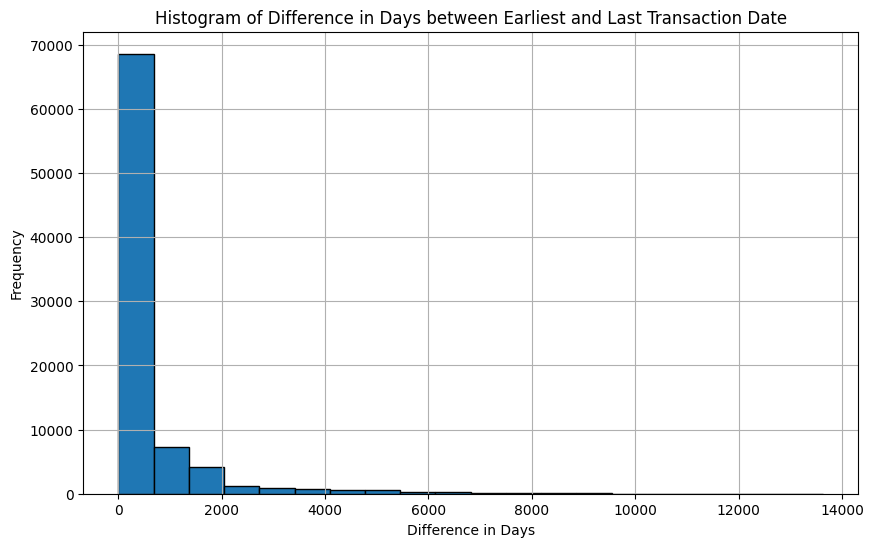

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(agg_df['DIFF_DAYS'], bins=20, edgecolor='black')  # Adjust bins as needed

# Add labels and title
plt.xlabel('Difference in Days')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in Days between Earliest and Last Transaction Date')

# Show plot
plt.grid(True)
plt.show()

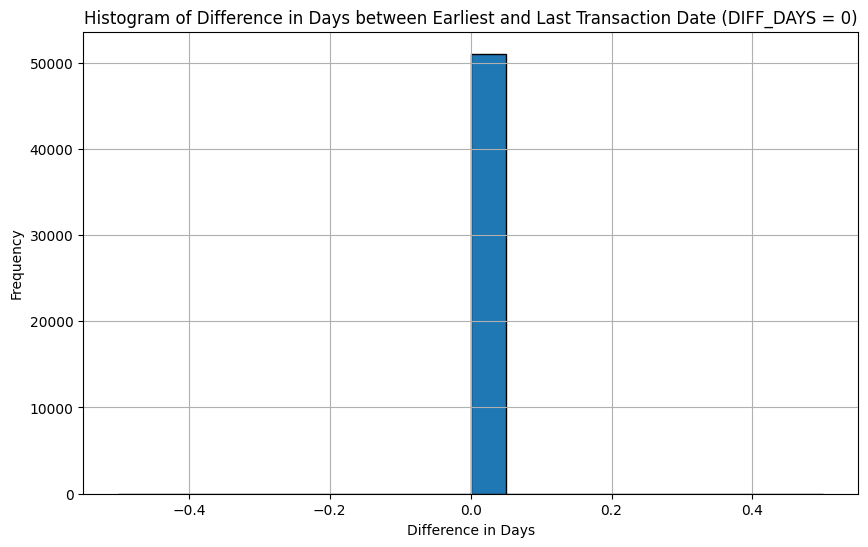

In [ ]:
# Filter agg_df to include only DIFF_DAYS equal to 0
filtered_diff_days = agg_df[agg_df['DIFF_DAYS'] == 0]['DIFF_DAYS']

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_diff_days, bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Difference in Days')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in Days between Earliest and Last Transaction Date (DIFF_DAYS = 0)')

# Show plot
plt.grid(True)
plt.show()

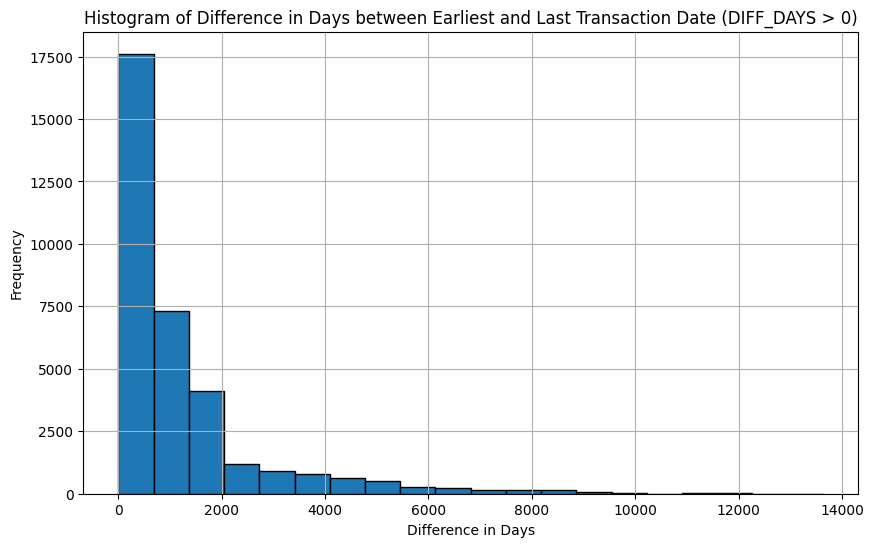

In [ ]:
# Filter agg_df to include only DIFF_DAYS greater than 0
filtered_diff_days = agg_df[agg_df['DIFF_DAYS'] > 0]['DIFF_DAYS']

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_diff_days, bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Difference in Days')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in Days between Earliest and Last Transaction Date (DIFF_DAYS > 0)')

# Show plot
plt.grid(True)
plt.show()

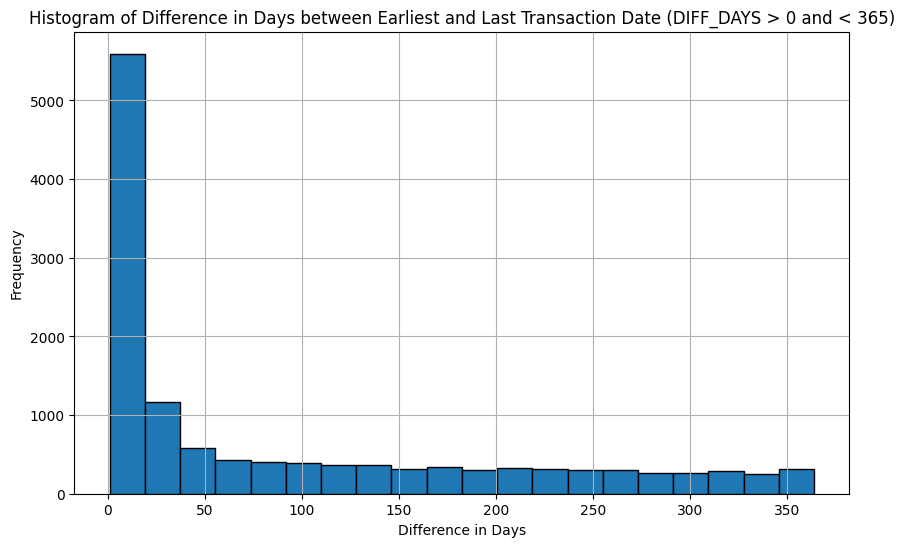

In [ ]:
# Filter agg_df to include only DIFF_DAYS greater than 0 and less than one year
filtered_diff_days = agg_df[(agg_df['DIFF_DAYS'] > 0) & (agg_df['DIFF_DAYS'] < 365)]['DIFF_DAYS']

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_diff_days, bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Difference in Days')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in Days between Earliest and Last Transaction Date (DIFF_DAYS > 0 and < 365)')

# Show plot
plt.grid(True)
plt.show()

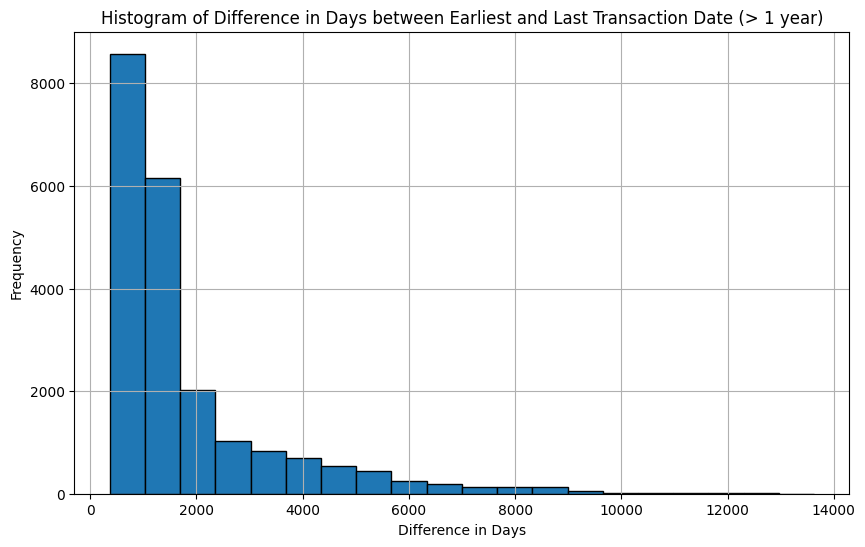

In [ ]:
# Filter agg_df to include only DIFF_DAYS greater than one year
filtered_diff_days = agg_df[agg_df['DIFF_DAYS'] > 365]['DIFF_DAYS']

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_diff_days, bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Difference in Days')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in Days between Earliest and Last Transaction Date (> 1 year)')

# Show plot
plt.grid(True)
plt.show()

In [ ]:
print('DIFF_DAYS greater than 1 year:', agg_df[agg_df['DIFF_DAYS'] > 365].shape[0])

DIFF_DAYS greater than 1 year: 21238


## Distribution of First Transaction Dates and Year

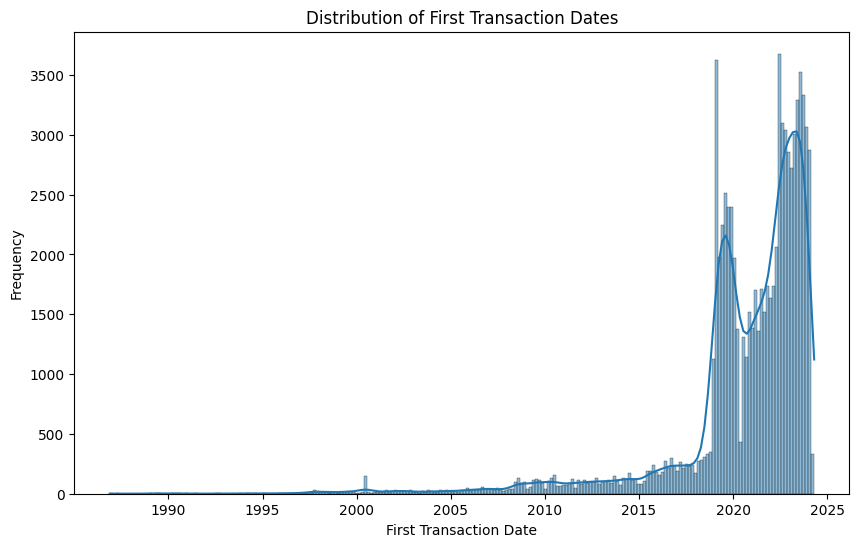

In [ ]:
# Plotting the distribution of first transaction dates
plt.figure(figsize=(10, 6))
sns.histplot(agg_df['FIRST_TRANS_DATE'], kde=True)

plt.xlabel('First Transaction Date')
plt.ylabel('Frequency')
plt.title('Distribution of First Transaction Dates')

plt.show()

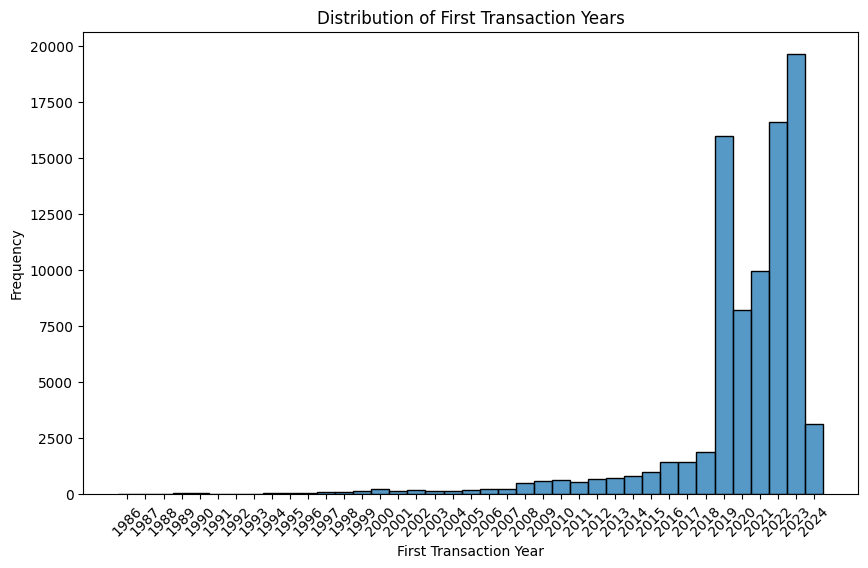

In [ ]:
# Plotting the distribution of first transaction years
plt.figure(figsize=(10, 6))
sns.histplot(agg_df['FIRST_TRANS_DATE'].dt.year, bins=range(1986, 2025), kde=False, discrete=True)

plt.xlabel('First Transaction Year')
plt.ylabel('Frequency')
plt.title('Distribution of First Transaction Years')
plt.xticks(range(1986, 2025), rotation=45)

plt.show()

There is a significant spike in the year 2019.

## Distribution of Last Transaction Dates and Year

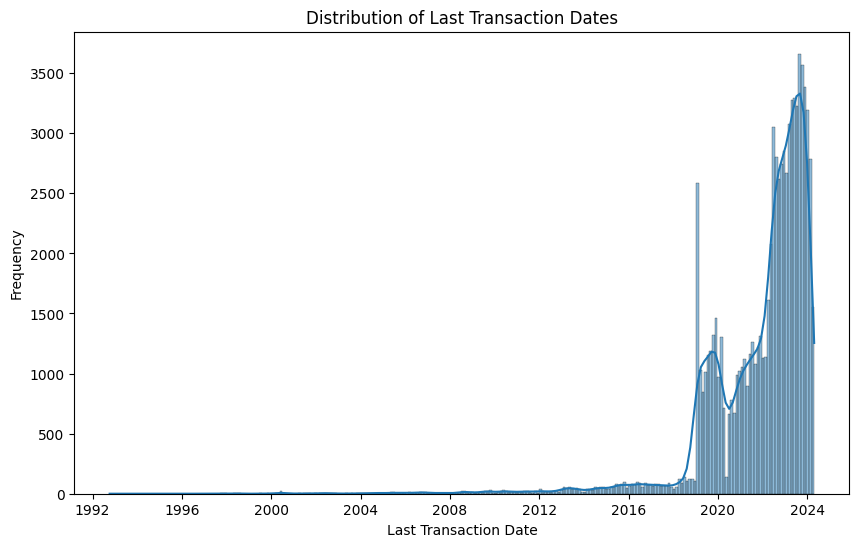

In [ ]:
# Plotting the distribution of LAST transaction dates
plt.figure(figsize=(10, 6))
sns.histplot(agg_df['LAST_TRANS_DATE'], kde=True)

plt.xlabel('Last Transaction Date')
plt.ylabel('Frequency')
plt.title('Distribution of Last Transaction Dates')

plt.show()

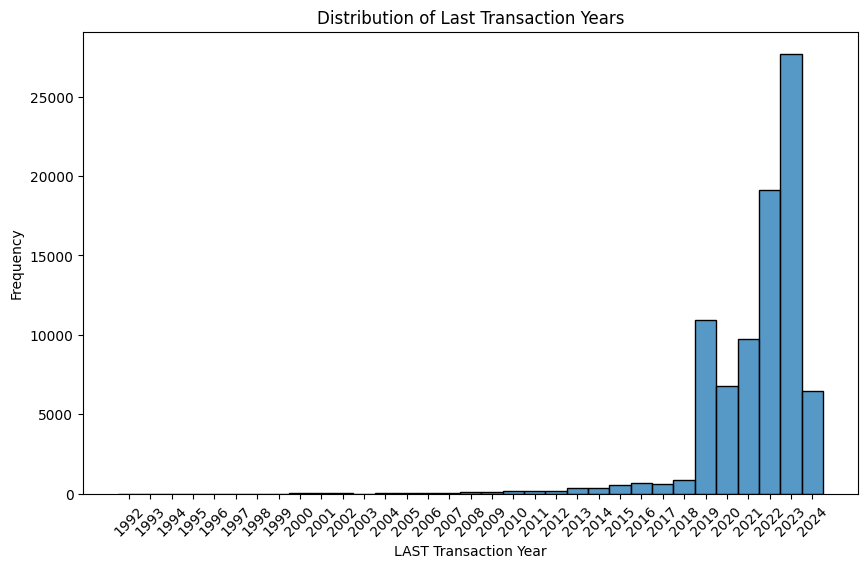

In [ ]:
# Plotting the distribution of Last transaction years
plt.figure(figsize=(10, 6))
sns.histplot(agg_df['LAST_TRANS_DATE'].dt.year, bins=range(1992, 2025), kde=False, discrete=True)

plt.xlabel('LAST Transaction Year')
plt.ylabel('Frequency')
plt.title('Distribution of Last Transaction Years')
plt.xticks(range(1992, 2025), rotation=45)

plt.show()

Almost the same distribution. This is because most customers don't last one year.

In [ ]:
print("Percentage customers lasting greater than one year: ", (agg_df[agg_df['DIFF_DAYS'] > 365].shape[0] / agg_df.shape[0]) * 100, '%')

Percentage customers lasting greater than one year:  24.93776713165187 %


#Recommendation Systems

In [ ]:
df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TRANSACTION_COUNT_DAY
33548,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday,1
15885,334094.0,1987-01-13,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Tuesday,1
116709,973756.0,1987-03-28,HEALTH & WELLNESS,Bulletproof,Luxurious,Saturday,1
13369,803423.0,1987-04-16,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Thursday,1
112280,728381.0,1987-06-15,HEALTH & WELLNESS,Bulletproof,Luxurious,Monday,1


Notes



*  Data is sparse. Most customers have only transacted once. So sequential recommendation is not recommended.
*  We try Alternating Least Squares (ALS)


## Data Preparation

### Copy of DataFrame

In [ ]:
rec_df = df.copy()
rec_df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TRANSACTION_COUNT_DAY
33548,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday,1
15885,334094.0,1987-01-13,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Tuesday,1
116709,973756.0,1987-03-28,HEALTH & WELLNESS,Bulletproof,Luxurious,Saturday,1
13369,803423.0,1987-04-16,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Thursday,1
112280,728381.0,1987-06-15,HEALTH & WELLNESS,Bulletproof,Luxurious,Monday,1


### Remove `TRANSACTION_COUNT_DAY`

In [ ]:
rec_df.drop('TRANSACTION_COUNT_DAY', axis=1, inplace=True)
rec_df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK
33548,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday
15885,334094.0,1987-01-13,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Tuesday
116709,973756.0,1987-03-28,HEALTH & WELLNESS,Bulletproof,Luxurious,Saturday
13369,803423.0,1987-04-16,HEALTH & WELLNESS,Bulletproof,Cost-Conscious,Thursday
112280,728381.0,1987-06-15,HEALTH & WELLNESS,Bulletproof,Luxurious,Monday


### Feature Engineering - Rating

#### Total Transactions per Customer

In [ ]:
'''# Count the total number of unique transaction dates per customer
transaction_counts = rec_df.groupby(['CST_ID', 'TRANS_DATE']).size().groupby(level=0).size().reset_index(name='TOTAL_TRANSACTIONS')

# Merge the count back into the original DataFrame
rec_df = rec_df.merge(transaction_counts, on='CST_ID')

rec_df.head()'''

# Calculate TOTAL_TRANSACTIONS as the total number of times each CST_ID appears
transaction_counts = rec_df.groupby('CST_ID').size().reset_index(name='TOTAL_TRANSACTIONS')

# Merge the count back into the original DataFrame
rec_df = rec_df.merge(transaction_counts, on='CST_ID')

rec_df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TOTAL_TRANSACTIONS
0,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday,6
1,517952.0,2002-02-20,HEALTH & WELLNESS,New Chapter,Luxurious,Wednesday,6
2,517952.0,2023-05-26,SNACKS,Triscuit,Luxurious,Friday,6
3,517952.0,2023-07-08,SNACKS,Lay's,Luxurious,Saturday,6
4,517952.0,2023-07-31,SNACKS,Triscuit,Luxurious,Monday,6


In [ ]:
rec_df[rec_df['TRANS_DATE'] == '2024-04-24']

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TOTAL_TRANSACTIONS
22385,609202.0,2024-04-24,SNACKS,Clif Bar,Luxurious,Wednesday,54
41541,230308.0,2024-04-24,SNACKS,Lay's,Cost-Conscious,Wednesday,3
98211,124689.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Cost-Conscious,Wednesday,5
113489,743227.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Monthly,Wednesday,3
129675,372071.0,2024-04-24,HEALTH & WELLNESS,Nordic Naturals,Cost-Conscious,Wednesday,3
135895,70950.0,2024-04-24,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious,Wednesday,4
149252,372782.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Cost-Conscious,Wednesday,5
149253,372782.0,2024-04-24,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious,Wednesday,5
161690,44574.0,2024-04-24,SNACKS,Lay's,Luxurious,Wednesday,1


In [ ]:
rec_df[rec_df['CST_ID'] == 	372782.0]

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TOTAL_TRANSACTIONS
149249,372782.0,2023-08-17,SNACKS,Lay's,Cost-Conscious,Thursday,5
149250,372782.0,2023-08-29,SNACKS,Larabar,Cost-Conscious,Tuesday,5
149251,372782.0,2024-04-13,HEALTH & WELLNESS,Four Sigmatic,Cost-Conscious,Saturday,5
149252,372782.0,2024-04-24,HEALTH & WELLNESS,Garden of Life,Cost-Conscious,Wednesday,5
149253,372782.0,2024-04-24,HEALTH & WELLNESS,Nature's Bounty,Cost-Conscious,Wednesday,5


5 Total Transactions.

#### Number of times a product has been bought by a single customer

In [ ]:
# Count the number of times each product is bought by each customer
product_counts = rec_df.groupby(['CST_ID', 'PRODUCT_BRAND']).size().reset_index(name='PRODUCT_PURCHASE_COUNT')

# Merge the product count back into the original DataFrame
rec_df = rec_df.merge(product_counts, on=['CST_ID', 'PRODUCT_BRAND'])
rec_df.head()

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT
0,517952.0,1986-11-16,HEALTH & WELLNESS,Bulletproof,Luxurious,Sunday,6,1
1,517952.0,2002-02-20,HEALTH & WELLNESS,New Chapter,Luxurious,Wednesday,6,2
2,517952.0,2024-03-13,HEALTH & WELLNESS,New Chapter,Luxurious,Wednesday,6,2
3,517952.0,2023-05-26,SNACKS,Triscuit,Luxurious,Friday,6,2
4,517952.0,2023-07-31,SNACKS,Triscuit,Luxurious,Monday,6,2


#### Filter DataFrame with needed columns only

In [ ]:
rec_df = rec_df[['CST_ID', 'PRODUCT_BRAND', 'TOTAL_TRANSACTIONS', 'PRODUCT_PURCHASE_COUNT']]
rec_df.head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT
0,517952.0,Bulletproof,6,1
1,517952.0,New Chapter,6,2
2,517952.0,New Chapter,6,2
3,517952.0,Triscuit,6,2
4,517952.0,Triscuit,6,2


#### Check Duplicates

In [ ]:
duplicates = rec_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 12336


In [ ]:
rec_df.drop_duplicates(inplace=True)
rec_df.head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT
0,517952.0,Bulletproof,6,1
1,517952.0,New Chapter,6,2
3,517952.0,Triscuit,6,2
5,517952.0,Lay's,6,1
6,334094.0,Bulletproof,4,1


#### Rating Formula

Let $X$ be the `PRODUCT_PURCHASE_COUNT`.

Let $Y$ be the `TOTAL_TRANSACTIONS`.

Then, we have $\text{Rating} = 1 + 4 \cdot \text{minmax}(\frac{X}{Y})$.

In [ ]:
# Calculate the initial rating using the given formula
rec_df["RATING"] = rec_df["PRODUCT_PURCHASE_COUNT"] / rec_df["TOTAL_TRANSACTIONS"]

# Find the minimum and maximum of the initial ratings
min_rating = rec_df["RATING"].min()
max_rating = rec_df["RATING"].max()

# Normalize the initial ratings to a 1-5 scale
rec_df["RATING"] = 1 + 4 * (rec_df["RATING"] - min_rating) / (max_rating - min_rating)

rec_df.head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
0,517952.0,Bulletproof,6,1,1.643026
1,517952.0,New Chapter,6,2,2.314421
3,517952.0,Triscuit,6,2,2.314421
5,517952.0,Lay's,6,1,1.643026
6,334094.0,Bulletproof,4,1,1.978723


In [ ]:
rec_df[rec_df['TOTAL_TRANSACTIONS'] == 1].head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
347,918943.0,Bulletproof,1,1,5.0
428,278715.0,Bulletproof,1,1,5.0
509,379506.0,Reno's,1,1,5.0
584,724907.0,New Chapter,1,1,5.0
684,730805.0,Reno's,1,1,5.0


#### Ratings Visualization

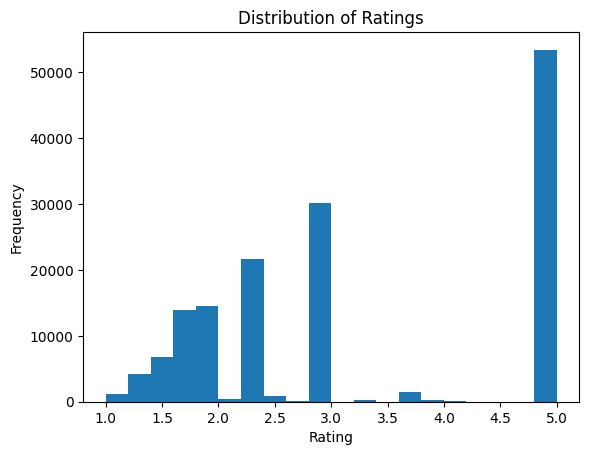

In [ ]:
plt.hist(rec_df["RATING"], bins=20)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

More 5 stars now because single transactions for one CST_ID is assumed to be 5 stars.

In [ ]:
rec_df[rec_df['RATING'] == 5].head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
347,918943.0,Bulletproof,1,1,5.0
428,278715.0,Bulletproof,1,1,5.0
509,379506.0,Reno's,1,1,5.0
584,724907.0,New Chapter,1,1,5.0
684,730805.0,Reno's,1,1,5.0


In [ ]:
rec_df[(rec_df['RATING'] > 3) & (rec_df['RATING'] < 5)].head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
555,95839.0,Nature's Bounty,3,2,3.657210
560,193906.0,Clif Bar,7,4,3.273556
1029,603665.0,Clif Bar,19,15,4.151922
1244,947967.0,Nature's Bounty,3,2,3.657210
1337,229291.0,Nature's Bounty,3,2,3.657210


In [ ]:
rec_df[rec_df['RATING'] == 1]

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
3181,324028.0,Garden of Life,142,1,1.0
3307,324028.0,Triscuit,142,1,1.0
3308,324028.0,Fritos,142,1,1.0
3309,324028.0,Wheat Thins,142,1,1.0
3316,324028.0,San Miguel,142,1,1.0
3320,324028.0,Amazing Grass,142,1,1.0


In [ ]:
rec_df[rec_df['CST_ID'] == 117048.0]
#This problem is solved

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
130766,117048.0,Lay's,3,3,5.0


In [ ]:
lays_rec_df = rec_df[rec_df['PRODUCT_BRAND'] == 'Lay\'s']
lays_rec_df[lays_rec_df['RATING'] == 5].head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
40704,987118.0,Lay's,2,2,5.0
40829,616408.0,Lay's,2,2,5.0
41148,767532.0,Lay's,1,1,5.0
41160,871970.0,Lay's,1,1,5.0
41273,506829.0,Lay's,1,1,5.0


Problem with this rating: if a customer buys 1 item that is typically bought one at a time for many days but the customer also buys lots of other items along with the 1 item, the rating will go down.

In [ ]:
rec_df[rec_df['CST_ID'] == 	426721.0]

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
60464,426721.0,Lay's,2,1,2.985816
60465,426721.0,Goldfish,2,1,2.985816


## Alternating Least Squares

### Create Copy of DataFrame

In [ ]:
als_df = rec_df.copy()
als_df.head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
0,517952.0,Bulletproof,6,1,1.643026
1,517952.0,New Chapter,6,2,2.314421
3,517952.0,Triscuit,6,2,2.314421
5,517952.0,Lay's,6,1,1.643026
6,334094.0,Bulletproof,4,1,1.978723


### Convert `PRODUCT_BRAND` to numerical categories

In [ ]:
als_df['PRODUCT_BRAND'] = als_df['PRODUCT_BRAND'].astype('category')
brand_mapping = dict(enumerate(als_df['PRODUCT_BRAND'].cat.categories))
brand_mapping

{0: 'Ajinomoto',
 1: "Aling Tonya's",
 2: 'Amazing Grass',
 3: "Angie's",
 4: "Angie's Boomchickapop",
 5: "Annie Chun's",
 6: "Annie's Homegrown",
 7: 'Ariel',
 8: "Barbara's Bakery",
 9: 'Bare Snacks',
 10: 'BelVita',
 11: 'Blue Bay',
 12: 'Blue Diamond Almonds',
 13: 'Boom Chicka Pop',
 14: 'Bulletproof',
 15: 'Cape Cod Chips',
 16: 'Cheetos',
 17: 'Cheez-It',
 18: 'Chips Ahoy!',
 19: 'Cif',
 20: 'Clif Bar',
 21: 'Clorox',
 22: 'Coca-Cola',
 23: 'Dang Foods',
 24: 'Datu Puti',
 25: 'Del Monte',
 26: 'Domex',
 27: 'Doritos',
 28: 'Downy',
 29: 'Emerald Nuts',
 30: 'Enjoy Life',
 31: 'Fiber One Bars',
 32: 'Fig Newtons',
 33: 'Fisher Farms',
 34: 'Four Sigmatic',
 35: 'Fresh Options',
 36: 'Fritos',
 37: 'Gaia Herbs',
 38: 'Garden of Life',
 39: 'GoMacro',
 40: 'Goldfish',
 41: "Herr's",
 42: 'Hippeas',
 43: 'Joy',
 44: "Justin's",
 45: 'KIND Snacks',
 46: 'Kashi',
 47: 'Kettle Brand Chips',
 48: 'Kind Bar',
 49: 'Larabar',
 50: "Lay's",
 51: "Lenny & Larry's",
 52: 'LesserEvil',
 53:

In [ ]:
als_df['PRODUCT_BRAND'] = als_df['PRODUCT_BRAND'].cat.codes
als_df.head()

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
0,517952.0,14,6,1,1.643026
1,517952.0,68,6,2,2.314421
3,517952.0,116,6,2,2.314421
5,517952.0,50,6,1,1.643026
6,334094.0,14,4,1,1.978723


### Convert to Appropriate Matrix for ALS

In [ ]:
als_df = als_df[['CST_ID', 'PRODUCT_BRAND', 'RATING']]
als_df.head()

,CST_ID,PRODUCT_BRAND,RATING
0,517952.0,14,1.643026
1,517952.0,68,2.314421
3,517952.0,116,2.314421
5,517952.0,50,1.643026
6,334094.0,14,1.978723


In [ ]:
als_df = als_df.pivot(index='CST_ID', columns='PRODUCT_BRAND', values='RATING').fillna(0)
als_df.head()

PRODUCT_BRAND,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
CST_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.985816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.985816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.314421,0.0,2.314421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.314421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.985816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.985816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ALS Implementation

In [ ]:
# Create Spark session
spark = SparkSession.builder.appName('ALSRecommendation').getOrCreate()

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(als_df)

# Select required columns and rename them for ALS
als_data = spark_df.selectExpr('CST_ID as userId', 'PRODUCT_BRAND as itemId', 'RATING as rating')

# Show the data
als_data.show()

+--------+------+------------------+
|  userId|itemId|            rating|
+--------+------+------------------+
|517952.0|    14|1.6430260047281324|
|517952.0|    68|2.3144208037825056|
|517952.0|   116|2.3144208037825056|
|517952.0|    50|1.6430260047281324|
|334094.0|    14|1.9787234042553192|
|334094.0|    88|2.9858156028368796|
|334094.0|   118|1.9787234042553192|
|973756.0|    14|1.9787234042553192|
|973756.0|    68|1.9787234042553192|
|973756.0|   107|1.9787234042553192|
|973756.0|    60|1.9787234042553192|
|803423.0|    14|1.7773049645390073|
|803423.0|    68|1.7773049645390073|
|803423.0|    34|1.7773049645390073|
|803423.0|    38|1.7773049645390073|
|803423.0|    67|1.7773049645390073|
|728381.0|    14|1.9787234042553192|
|728381.0|    68|1.9787234042553192|
|728381.0|    38|1.9787234042553192|
|728381.0|    57|1.9787234042553192|
+--------+------+------------------+
only showing top 20 rows



In [ ]:
rec_df[rec_df['CST_ID'] == 517952.0]

,CST_ID,PRODUCT_BRAND,TOTAL_TRANSACTIONS,PRODUCT_PURCHASE_COUNT,RATING
0,517952.0,Bulletproof,6,1,1.643026
1,517952.0,New Chapter,6,2,2.314421
3,517952.0,Triscuit,6,2,2.314421
5,517952.0,Lay's,6,1,1.643026


In [ ]:
# Initialize the ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="itemId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Split the data into training and test sets
(training, test) = als_data.randomSplit([0.8, 0.2])

# Train the model
model = als.fit(training)

In [ ]:
# Make predictions
predictions = model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Show some predictions
predictions.show()

Root-mean-square error = 0.4943663797960865
+--------+------+------------------+----------+
|  userId|itemId|            rating|prediction|
+--------+------+------------------+----------+
|   833.0|    10|1.7773049645390073| 1.4284556|
| 13285.0|    36|1.6430260047281324|  1.671696|
| 22373.0|    60|1.9787234042553192| 1.8206487|
| 47711.0|    92|2.9858156028368796| 2.1245642|
| 74904.0|    50|2.9858156028368796| 2.8456469|
|101775.0|    50|2.9858156028368796|  2.938056|
|158593.0|    83|2.3144208037825056|   1.57247|
|158593.0|    92|2.3144208037825056| 1.6468316|
|158803.0|    14| 1.475177304964539| 1.4722244|
|176948.0|    50|2.9858156028368796| 1.5873032|
|176948.0|    67|1.6430260047281324| 1.4419749|
|180155.0|    66|2.9858156028368796| 2.5399609|
|185494.0|    68|1.9787234042553192| 1.7038267|
|244128.0|    50|2.9858156028368796|   2.85227|
|322355.0|    26|1.7773049645390073| 1.5545852|
|390488.0|    50|2.3144208037825056| 2.2826068|
|444547.0|    92|2.9858156028368796| 2.12456

#### Testing Example Products

In [ ]:
#Enter Customer ID here
id = 426721.0

# Initialize Spark session
spark = SparkSession.builder.appName("ALSExample").getOrCreate()

# Define schema for new data
schema = StructType([
    StructField("userId", FloatType(), True),
    StructField("itemId", IntegerType(), True)
])

# List to collect new data tuples
new_data_list = []

# Example loop to add tuples to the list
for i in range(128):  # Simulating adding 10 tuples; adjust as needed
    # Example tuple; replace with your logic to get userId and itemId
    userId = id
    itemId = i
    new_data_list.append((userId, itemId))

# Convert the list to DataFrame
new_data = spark.createDataFrame(new_data_list, schema)

# Predict ratings for the new data
new_predictions = model.transform(new_data)

# Sort the predictions in descending order by the predicted rating
sorted_predictions = new_predictions.orderBy(new_predictions["prediction"].desc())

# Define a UDF to map itemId to PRODUCT_BRAND
def map_item_to_brand(item_id):
    return brand_mapping.get(item_id, "Unknown")

# Register the UDF
item_to_brand_udf = udf(map_item_to_brand, StringType())

# Apply the UDF to replace itemId with PRODUCT_BRAND
new_predictions_with_brands = new_predictions.withColumn("PRODUCT_BRAND", item_to_brand_udf(new_predictions["itemId"]))

# Drop the itemId column
new_predictions_with_brands = new_predictions_with_brands.drop("itemId")

# Sort the predictions in descending order by the predicted rating
sorted_predictions = new_predictions_with_brands.orderBy(new_predictions_with_brands["prediction"].desc())

# Show the sorted predictions
sorted_predictions.show()

+--------+----------+-------------------+
|  userId|prediction|      PRODUCT_BRAND|
+--------+----------+-------------------+
|426721.0| 2.9264464|              Lay's|
|426721.0| 2.7881374|           Goldfish|
|426721.0| 2.7410831|            Doritos|
|426721.0| 2.5462477|Snyder's of Hanover|
|426721.0| 2.5319798|          Del Monte|
|426721.0| 2.4861822|    Nature's Bounty|
|426721.0|  2.406672|  Quaker Chewy Bars|
|426721.0| 2.3772435|            SeaKing|
|426721.0| 2.3613558|             Fritos|
|426721.0|  2.347604|             Nestlé|
|426721.0| 2.3251414|           Pringles|
|426721.0| 2.2967482|           Monterey|
|426721.0| 2.2882617|          Ajinomoto|
|426721.0|  2.237793|      Nature Valley|
|426721.0| 2.2228928|           Triscuit|
|426721.0| 2.2064981|            Ruffles|
|426721.0| 2.1855686|     Garden of Life|
|426721.0| 2.1636674|            Larabar|
|426721.0| 2.1614673|             Reno's|
|426721.0|  2.124536|       Fisher Farms|
+--------+----------+-------------

In [ ]:
df[df['CST_ID'] == id]

,CST_ID,TRANS_DATE,PRODUCT_TYPE,PRODUCT_BRAND,SHOPPER,DAY_OF_WEEK,TRANSACTION_COUNT_DAY
56987,426721.0,2019-07-18,SNACKS,Lay's,Monthly,Thursday,1
56986,426721.0,2021-12-29,SNACKS,Goldfish,Monthly,Wednesday,1


In [ ]:
# Example: Predict rating for a specific customer and product
new_data = spark.createDataFrame([
    (id, 40),  # customerId, Lays
], ["userId", "itemId"])

# Predict ratings for the new data
new_predictions = model.transform(new_data)
new_predictions.show()

+--------+------+----------+
|  userId|itemId|prediction|
+--------+------+----------+
|426721.0|    40| 2.7881374|
+--------+------+----------+

